### Imports

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import glob
from oak_cli.evaluation.resources.main import ResourcesCSVKeys
from oak_cli.evaluation.addons.flops.main import FLOpsExclusiveCSVKeys, EvaluationRunFLOpsProjectStage, FLOPS_STAGES_INDEX_MAP, TRAINED_MODEL_PERFORMANCE_CSV, FLOpsTrainedModelCSVKeys
from oak_cli.evaluation.common import get_csv_dir_for_scenario
from oak_cli.evaluation.types import EvaluationScenario
from oak_cli.evaluation.graph_utils import get_evaluation_run_duration_label, adjust_xticks
from typing import List, Callable, Optional, Tuple
from pydantic import BaseModel
import pathlib
from oak_cli.utils.logging import logger
from icecream import ic

### Constants

In [20]:
#csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)

csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_mnist_sklearn_small_without_baseimages")

### Auxiliary

In [21]:
CPU_KEY = ResourcesCSVKeys.CPU_USAGE.value
MEMORY_KEY = ResourcesCSVKeys.MEMORY_USAGE.value
TIME_START_KEY = ResourcesCSVKeys.TIME_SINCE_START.value
RUN_ID_KEY = ResourcesCSVKeys.EVALUATION_RUN_ID.value


def draw_graph(
        title: str,
        plot_function: Optional[Callable] = None,
        data: Optional[pd.DataFrame] = None,
        y_lable: str = "Resource Usage (%)",
        size: Tuple[int,int] = (10, 5),
    ) -> None:
    fig, ax = plt.subplots(figsize=size)
    ax.set_title(title)

    #sns.lineplot(data=data)
    if not plot_function:
        sns.lineplot(data=data)
    else:
        plot_function()
    plt.xlabel(get_evaluation_run_duration_label())
    plt.ylabel(y_lable)
    adjust_xticks(ax)
    plt.xlim([0, max(df.index)])
    plt.ylim(0, 100)

    plt.show()


### Settings

In [22]:
USE_MINUTES = True

### Error Handing & Checking

In [23]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Common Graph Configuration

In [24]:
csv_files = glob.glob(f'{csv_dir}/evaluation_run_*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

trained_model_df = pd.read_csv(TRAINED_MODEL_PERFORMANCE_CSV)

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[TIME_START_KEY]] = df[[TIME_START_KEY]].astype(int)

df.set_index(TIME_START_KEY, inplace=True)

if USE_MINUTES:
    df.index = df.index / 60

singular_run_df = df[df[RUN_ID_KEY] == (df[RUN_ID_KEY].max() // 2)]

### Common Graph Styling

In [25]:
sns.set_style("whitegrid")
flops_palette = "rainbow"

---

# Graphs Drawing

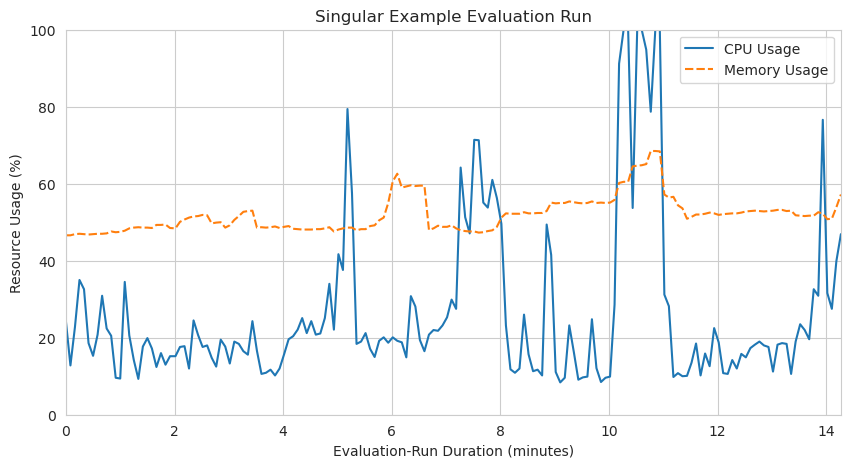

In [26]:
# CPU & Memory Usage of Single Evaluation Run
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[CPU_KEY, MEMORY_KEY]],
)

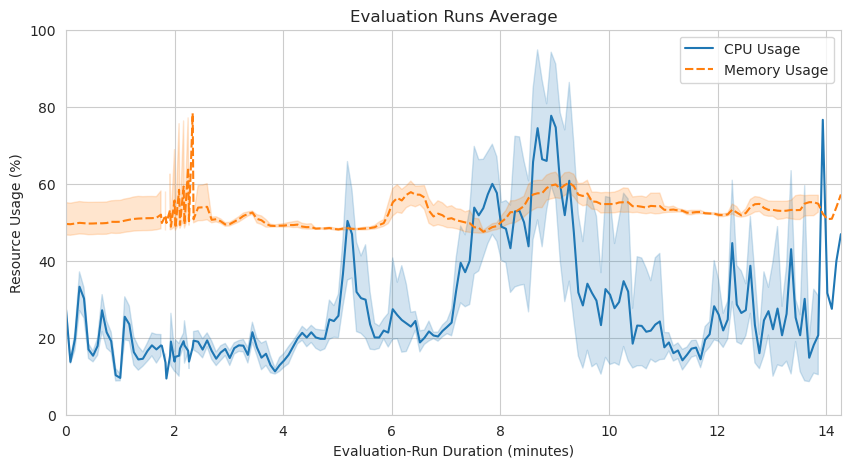

In [27]:
# CPU & Memory Usage of All/Average Evaluation Runs
draw_graph(
    title="Evaluation Runs Average",
    data=df[[CPU_KEY, MEMORY_KEY]],
)

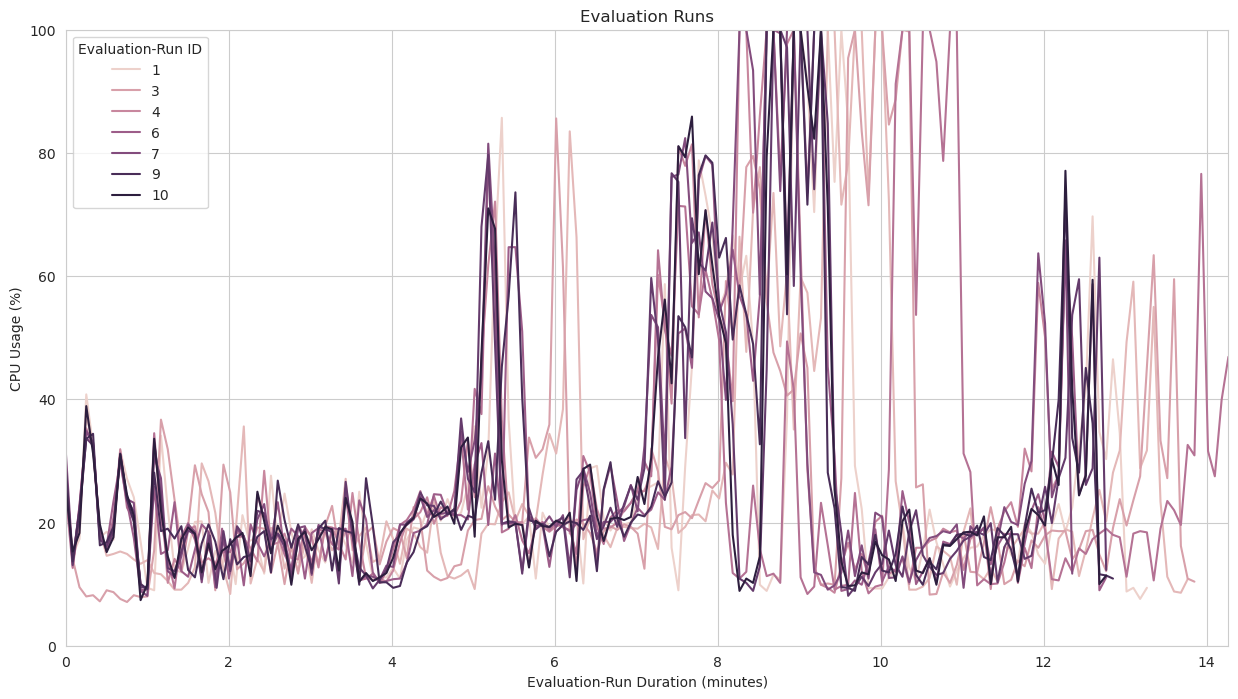

In [28]:
# CPU Usage of all Evaluation Runs
draw_graph(
    title="Evaluation Runs",
    y_lable="CPU Usage (%)",
    size=(15, 8),
    plot_function=lambda: sns.lineplot(
        data=df,
        x=TIME_START_KEY,
        y=CPU_KEY,
        hue=RUN_ID_KEY,
    )
)

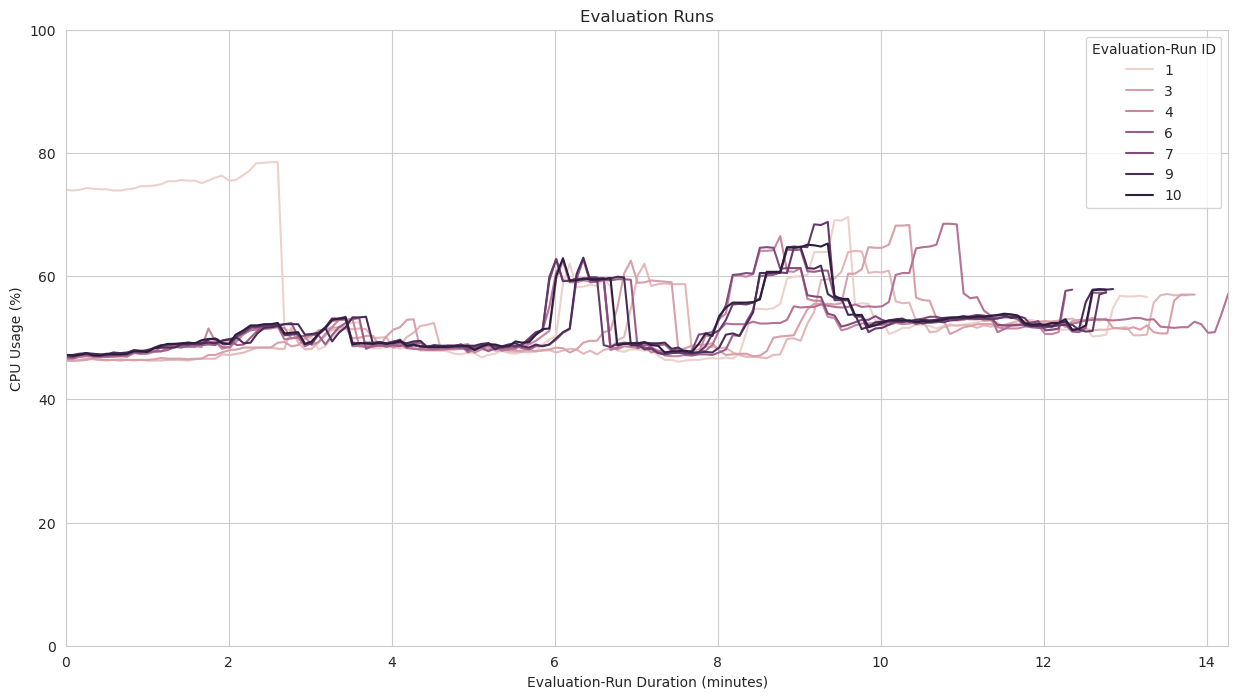

In [29]:
# Memory Usage of all Evaluation Runs
draw_graph(
    title="Evaluation Runs",
    y_lable="CPU Usage (%)",
    size=(15, 8),
    plot_function=lambda: sns.lineplot(
        data=df,
        x=TIME_START_KEY,
        y=MEMORY_KEY,
        hue=RUN_ID_KEY,
    )
)

---
---

In [30]:
#sns.color_palette(palette=flops_palette, n_colors=4)
#sns.color_palette(palette="hsv", n_colors=4)
sns.color_palette(palette="tab10", n_colors=4)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

NameError: name 'CPU_AND_MEMORY_KEYS' is not defined

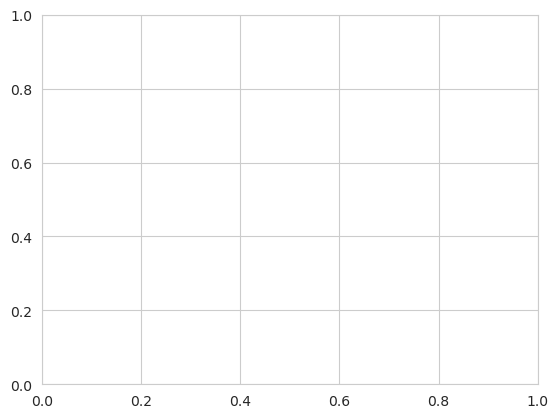

In [31]:
fig, ax = plt.subplots()

#df = df[df[ResourcesCSVKeys.EVALUATION_RUN_ID.value] == 1] 

#_df = 

sns.lineplot(data=df[CPU_AND_MEMORY_KEYS])

class Stage_Info(BaseModel):
    stage: EvaluationRunFLOpsProjectStage
    start: float = 0
    end: float = 0

stages: List[Stage_Info] = []
last_stage = ""
for index, row in df.iterrows():
    current_stage = EvaluationRunFLOpsProjectStage(row[FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value])

    if last_stage == "":
        last_stage = current_stage
        stages.append(Stage_Info(start=0, stage=current_stage))

    if last_stage != current_stage:
        last_stage = current_stage
        plt.axvline(x=index, color='grey', linestyle='--', ymax=100)
        _last_stage = stages[-1]
        _last_stage.end = float(index)
        next_stage = Stage_Info(start=index, stage=current_stage)
        stages.append(next_stage)

stages[-1].end = max(df.index)
for stage_info in stages:
    plt.fill_between(
        (stage_info.start,stage_info.end),
        100,
        color=sns.color_palette(palette="tab10", n_colors=len(list(FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE)))[FLOPS_STAGES_INDEX_MAP[stage_info.stage]],
        #alpha=0.1
        alpha=0.3
    )

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Resource Usage (%)")

plt.xlim([0, max(df.index)])
plt.ylim(0, 100)

plt.show()

In [ ]:
plt.figure(figsize=(25, 10)) 
sns.violinplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.CPU_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    alpha=0.3,
    palette=flops_palette,
)
sns.boxplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.CPU_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    palette=flops_palette,
)

plt.ylim(0, 100)
plt.show()

In [ ]:
plt.figure(figsize=(25, 10)) 
sns.violinplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.MEMORY_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    alpha=0.3,
    palette=flops_palette,
)
sns.boxplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.MEMORY_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    palette=flops_palette,
)

#plt.ylim(0, 100)
plt.show()

In [ ]:
plt.figure(figsize=(30, 10)) 
sns.countplot(x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value, data=df, palette=flops_palette)

plt.ylabel("Number of Time Samples (~Duration of a Stage)")

plt.show()

### Disk Space Changes

In [ ]:
fig, ax = plt.subplots()

disk_space_key = ResourcesCSVKeys.DISK_SPACE_CHANGE_SINCE_START.value

# Note: Change MB to GB
df[[disk_space_key]] = df[[disk_space_key]] / 1024

sns.lineplot(data=df[[disk_space_key]])
#sns.lineplot(data=df, x=ResourcesCSVKeys.TIME_SINCE_START.value, y=disk_space_key, hue=ResourcesCSVKeys.EVALUATION_RUN_ID.value)

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Disk Space Change (GB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

In [ ]:
fig, ax = plt.subplots()

disk_space_key = ResourcesCSVKeys.DISK_SPACE_CHANGE_SINCE_LAST_MEASUREMENT.value

# Note: Change MB to GB
df[[disk_space_key]] = df[[disk_space_key]]

sns.lineplot(data=df[[disk_space_key]])

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Disk Space Change Between Measurements (MB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

### Network

### Since Start

In [ ]:
fig, ax = plt.subplots()

NETWORK_COMPARED_TO_START_KEYS = [ResourcesCSVKeys.NETWORK_RECEIVED_SINCE_START.value, ResourcesCSVKeys.NETWORK_SENT_SINCE_START.value]

sns.lineplot(data=df[NETWORK_COMPARED_TO_START_KEYS] / 1024)

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Network Change (GB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

### Network compared: current vs last

In [ ]:
NETWORK_COMPARED_TO_LAST_MEASUREMENT_KEYS = [ResourcesCSVKeys.NETWORK_RECEIVED_COMPARED_TO_LAST_MEASUREMENT.value, ResourcesCSVKeys.NETWORK_SENT_COMPARED_TO_LAST_MEASUREMENT.value]

sns.lineplot(data=df[NETWORK_COMPARED_TO_LAST_MEASUREMENT_KEYS])
plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Network Changes Between Measurements (MB)")

# Constrain axes e.g. start at 0
plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

In [ ]:
accuracy_key = FLOpsTrainedModelCSVKeys.ACCURACY.value
trained_model_df[accuracy_key] = trained_model_df[accuracy_key] * 100
sns.barplot(y=accuracy_key,  data=trained_model_df, palette=flops_palette, hue=FLOpsTrainedModelCSVKeys.EVALUATION_RUN.value)

plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:

sns.barplot(y=FLOpsTrainedModelCSVKeys.LOSS.value,  data=trained_model_df, palette=flops_palette, hue=FLOpsTrainedModelCSVKeys.EVALUATION_RUN.value)
plt.show()

---

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))

#df = df[df[ResourcesCSVKeys.EVALUATION_RUN_ID.value] == 3] 
plt.subplot(1,2,1)
sns.lineplot(data=singular_run_df[[CPU_KEY, MEMORY_KEY]])
#sns.lineplot(data=df[[CPU_KEY, MEMORY_KEY]])
plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Resource Usage (%)")
#adjust_xticks(ax)
plt.xlim([0, max(df.index)])
plt.ylim(0, 100)


plt.subplot(1,2,2)
sns.lineplot(data=df, x=TIME_START_KEY, y=CPU_KEY, hue=RUN_ID_KEY)
plt.xlim([0, max(df.index)])
plt.ylim(0, 100)

plt.show()